In [3]:
import os
import cv2
import shutil
import numpy as np
#import rasterio.features
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from copy import deepcopy
from shapely import Polygon
from pathlib import Path
from skimage import measure
from shapely.plotting import plot_polygon
from utils import get_biggest_contour

In [3]:
DEBUG = False
fps = glob('../semantic_seg/wings/predictions/*')

for fp in tqdm(fps):
    fp = Path(fp)
    fn = fp.name
    seg_fp = Path('../semantic_seg/wings/to_predict/images') / fn
    if not os.path.exists(seg_fp):
        print('NOTE: SKIPPING SINCE IMAGE MISSING')
        continue
    seg = cv2.imread(seg_fp)
    
    
    pred = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    
    x_scale = seg.shape[1]/pred.shape[1]
    y_scale = seg.shape[0]/pred.shape[0]

    out = np.zeros(seg.shape[:2]).astype('uint8')
    for class_id in range(1,7):
        if (pred == class_id).sum() > 0:
            biggest_contour = get_biggest_contour((pred == class_id).astype('uint8')).squeeze()
            if len(biggest_contour) >= 4:
                poly = Polygon(biggest_contour*np.array([x_scale, y_scale]))
                class_mask_resized = rasterio.features.rasterize([poly], out_shape=(int(256*y_scale), int(256*x_scale)))
                out[np.where(class_mask_resized > 0.5)] = class_id
    if DEBUG:
        plt.imshow(out.astype('uint8'))

    new_fp = Path('../semantic_seg/wings/predictions_resized/') / fn
    cv2.imwrite(new_fp,out)
#plt.imshow(seg)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5714/5714 [02:27<00:00, 38.76it/s]


In [5]:
# Create final masks folder based on manual annotation if available, or mask if not
problem_wings = [
 '2024_06_05_h01bee19.png',
 '2024_06_05_h01bee27.png',
 '2024_06_05_h01bee32.png',
 '2024_06_05_h01bee45.png',
 '2024_06_06_h05bee07.png',
 '2024_06_06_h05bee11.png',
 '2024_06_07_h02bee03.png',
 '2024_06_07_h02bee34.png',
 '2024_06_07_h02bee38.png',
 '2024_06_10_h02b32.png',
 '2024_07_23_h21b28.png',
 ] 
img_fps = sorted(glob('../2_live_bees/9_UNet_predictions_resized/*'))


for img_fp in tqdm(img_fps):
    img_fp = Path(img_fp)
    fn = img_fp.name

    if fn in problem_wings:
        continue
    
    mask_fp = '../2_live_bees/9_UNet_predictions_resized/' + fn
    manual_mask_fp = '../2_live_bees/9_UNet_predictions_resized_manual_corrections/' + fn
    final_fp = '../2_live_bees/9_UNet_predictions_resized_final/' + fn

    if os.path.exists(manual_mask_fp):
        shutil.copyfile(manual_mask_fp, final_fp)
    else:
        shutil.copyfile(mask_fp, final_fp)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1193/1193 [00:00<00:00, 8786.20it/s]


In [4]:
# Plot overlaid
fps = glob('../2_live_bees/9_UNet_predictions_resized_final/*')
colors = (np.array(plt.get_cmap('Dark2').colors)*255).astype('uint8')

for fp in tqdm(fps):
    fp = Path(fp)
    fn = fp.name
    seg_fp = Path('../2_live_bees/6_cropped_and_flipped/') / fn
    if not os.path.exists(seg_fp):
        print('NOTE: SKIPPING SINCE IMAGE MISSING')
        continue
    seg = cv2.imread(seg_fp)
    pred = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)

    overlaid = deepcopy(seg)
    for class_id, color in zip(range(1,7), colors):
        color = tuple(color.astype('float'))
        if (pred == class_id).sum() > 0:
            biggest_contour = get_biggest_contour((pred == class_id).astype('uint8')).squeeze()
            overlaid = cv2.drawContours(overlaid, [biggest_contour], 0, color, -1)
    
    overlaid = cv2.addWeighted(overlaid, 0.9, seg, 0.1, 0)


    new_fp = Path('../2_live_bees/9_UNet_predictions_resized_final_overlaid/') / fn
    cv2.imwrite(new_fp,overlaid)
#plt.imshow(seg)

 24%|███████████████████████████████████▏                                                                                                            | 289/1182 [00:12<00:38, 23.13it/s]


KeyboardInterrupt: 

In [5]:
# Plot overlaid
fps = glob('../1_slides/6_UNet_predictions_resized/*')
colors = (np.array(plt.get_cmap('Dark2').colors)*255).astype('uint8')

for fp in tqdm(fps):
    fp = Path(fp)
    fn = fp.name
    seg_fp = Path('../1_slides/2_individual_wings/') / fn
    if not os.path.exists(seg_fp):
        print('NOTE: SKIPPING SINCE IMAGE MISSING')
        continue
    seg = cv2.imread(seg_fp)
    pred = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)

    overlaid = deepcopy(seg)
    for class_id, color in zip(range(1,7), colors):
        color = tuple(color.astype('float'))
        if (pred == class_id).sum() > 0:
            biggest_contour = get_biggest_contour((pred == class_id).astype('uint8')).squeeze()
            overlaid = cv2.drawContours(overlaid, [biggest_contour], 0, color, -1)
    
    overlaid = cv2.addWeighted(overlaid, 0.9, seg, 0.1, 0)


    new_fp = Path('../1_slides/6_UNet_predictions_resized_overlaid/') / fn
    cv2.imwrite(new_fp,overlaid)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [01:05<00:00, 68.50it/s]


In [95]:
c = plt.get_cmap('tab20')


array([[ 31, 119, 180],
       [174, 199, 232],
       [255, 127,  14],
       [255, 187, 120],
       [ 44, 160,  44],
       [152, 223, 138],
       [214,  39,  40],
       [255, 152, 150],
       [148, 103, 189],
       [197, 176, 213],
       [140,  86,  75],
       [196, 156, 148],
       [227, 119, 194],
       [247, 182, 210],
       [127, 127, 127],
       [199, 199, 199],
       [188, 189,  34],
       [219, 219, 141],
       [ 23, 190, 207],
       [158, 218, 229]], dtype=uint8)

(<matplotlib.patches.PathPatch at 0x716df517bd40>,
 <matplotlib.lines.Line2D at 0x716df51c5340>)

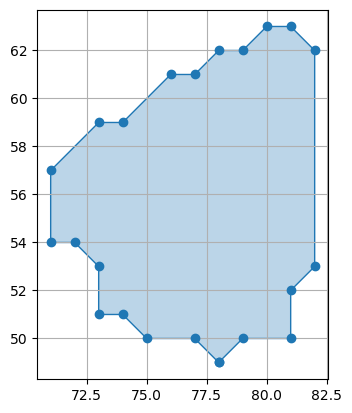

In [78]:

plot_polygon(Polygon(biggest_contour))

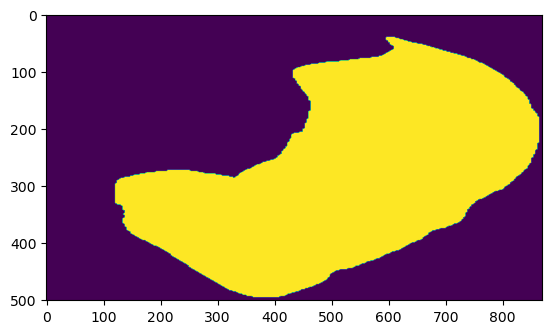

In [63]:


poly = Polygon(fwl_contours[0]*np.array([y_scale, x_scale]))
img = rasterio.features.rasterize([poly], out_shape=(int(256*x_scale), int(256*y_scale))).T
plt.imshow(img.astype('uint8'))

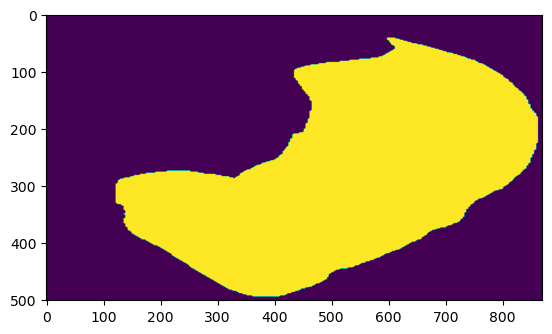

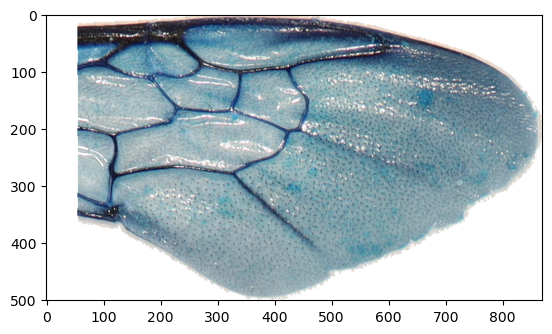

In [50]:
plt.imshow(seg)